In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xesmf
from glob import glob
from utils import fix_crocotime

In [72]:
grid = xr.open_dataset('../HINDCAST/CROCO_FILES/crococeazah_grd.nc')
crocopath = glob('../HINDCAST/OUTPUT/*avg*2022*')
croco     = xr.open_mfdataset(crocopath)['temp']
croco     = fix_crocotime(croco, YORIG='1950-01-01 00:00:00')
croco.coords['lon_rho'] = (croco.lon_rho+180)%360-180
sst = croco.isel(s_rho=-1).load().where(grid.mask_rho==1)

In [74]:
ostia = xr.open_mfdataset('~/storage/OSTIA/2022*').sel(lon=slice(-75.5,-70.5), lat=slice(-33.7,-27.3)).analysed_sst.load().reindex({'time':sst.time.values}, method='nearest')-273.15

In [75]:
reference        = ostia.copy()
husk             = xr.Dataset(coords={'lat':(['lat'], reference.lat.values, reference.lat.attrs),
                                      'lon':(['lon'], reference.lon.values, reference.lon.attrs)})
regridder = xesmf.Regridder(sst.rename({'lat_rho':'lat','lon_rho':'lon'}), reference, 'bilinear')
sst       = regridder(sst)

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


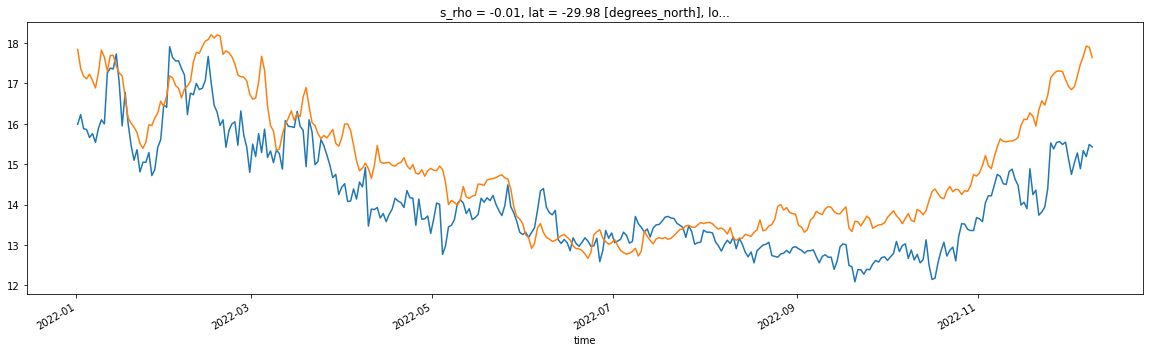

In [89]:
plt.figure(figsize=(20,5))
ostia.sel(lat=-30, lon=-71.5, method='nearest').plot()
sst.sel(lat=-30, lon=-71.5, method='nearest').plot()
